In [3]:
import requests
import numpy as np
import datasets
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

url = "https://raw.githubusercontent.com/cjhutto/vaderSentiment/master/vaderSentiment/vader_lexicon.txt"
response = requests.get(url)
text = response.text
lines = text.split("\n")
vader_lexicon = {}
for line in lines:
    tokens = line.split()
    if len(tokens) != 13:
        continue
    vader_lexicon.update({tokens[0]: float(tokens[1])})

def lowercase_punctuation(text):
    newtext = text.lower()
    # remove <br /> tags
    newtext = newtext.replace('<br />', '')
    # remove punctuation
    newtext = ''.join([c if c not in "\"#$%&()*+,./:;<=>?@[\]^_`{|}~" else ' ' for c in newtext])
    return newtext

def count_pronouns(word_list):
    count = 0
    for word in word_list:
        if word in ["i", "me", "mine", "my", "your", "yours", "yourselves", "you"]:
            count += 1
    return count

def lexicon_word_counter(word_list):
    positive_count = 0
    negative_count = 0
    for word in word_list:
        if word in vader_lexicon.keys():
            score = vader_lexicon[word]
            if score < -1:
                negative_count += 1
            elif score > 1:
                positive_count += 1
    return positive_count, negative_count

def vectorize_dataset(dataset):
    dataset_vectors = []
    for obj in dataset:
        word_list = lowercase_punctuation(obj['text']).split()
        check_no = 1 if word_list.__contains__('no') else 0
        nb_pronouns = count_pronouns(word_list)
        check_exclamation = 1 if word_list.__contains__('!') else 0
        log_nb_words = np.log(len(word_list))
        positive_count, negative_count = lexicon_word_counter(word_list)
        dataset_vectors.append([check_no, nb_pronouns, check_exclamation, log_nb_words, positive_count, negative_count])
    return dataset_vectors

train_dataset = datasets.load_dataset('imdb', split='train')


Found cached dataset imdb (C:/Users/theot/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


In [4]:
sentence_vectors = torch.tensor(vectorize_dataset(train_dataset), dtype=torch.float)
labels = torch.tensor(train_dataset['label'], dtype=torch.float).unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(
    sentence_vectors,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

In [5]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

tensor(0.9564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5831, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5832, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5833, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)
Training accuracy: 0.7148
Validation accuracy: 0.7167
Test accuracy: 0.6980
[0.3835625, 0.4019375, 0.4179375, 0.436375, 0.4515, 0.46425, 0.4779375, 0.4910625, 0.5051875, 0.5169375, 0.5295, 0.543375, 0.5553125, 0.566375, 0.576625, 0.5866875, 0.5959375, 0.6034375, 0.61125, 0.619625, 0.627125, 0.6330625, 0.6378125, 0.6425, 0.64625, 0.649875, 0.653125, 0.657, 0.6598125, 0.6629375, 0.6653125, 0.667, 0.6691875, 0.67125, 0.674125, 0.677, 0.6785, 0.680125, 0.68168

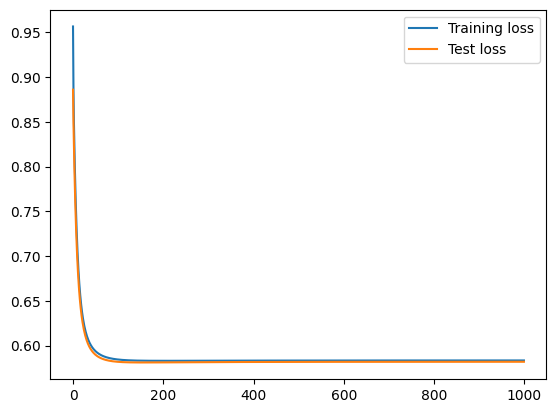

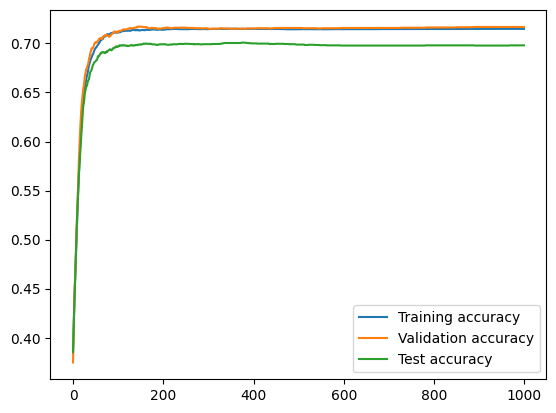

In [35]:
model = LogisticRegression(6, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []
train_accs = []
test_accs = []
valid_accs = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()
    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()
    # Calculer la précision sur l'ensemble d'entraînement
    train_preds = model(X_train).round().detach().cpu().numpy()
    train_acc = (train_preds == y_train.detach().cpu().numpy()).mean()
    train_accs.append(train_acc)

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)
        valid_preds = model(X_valid).round().detach().cpu().numpy()
        valid_acc = (valid_preds == y_valid.detach().cpu().numpy()).mean()
        valid_accs.append(valid_acc)
    
    test_preds = model(X_test).round().detach().cpu().numpy()
    test_acc = (test_preds == y_test.detach().cpu().numpy()).mean()
    test_accs.append(test_acc)


print(f"Training accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {valid_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

print(train_accs)
print(valid_accs)
print(test_accs)
plt.figure()
plt.plot(train_accs, label="Training accuracy")
plt.plot(valid_accs, label="Validation accuracy")
plt.plot(test_accs, label="Test accuracy")
plt.legend()
plt.show()

In [36]:
# Imprimer les précisions
print(f"Training accuracy: {train_accs[-1]:.3f}")
print(f"Validation accuracy: {valid_accs[-1]:.3f}")
print(f"Test accuracy: {test_accs[-1]:.3f}")

Training accuracy: 0.715
Validation accuracy: 0.717
Test accuracy: 0.698


In [27]:
#print the weights of the model
weights = model.classifier[0].weight.detach().numpy()[0].round(4)
features = ['check_no', 'nb_pronouns', 'check_exclamation', 'log_nb_words', 'positive_count', 'negative_count']
print(weights)
print(features)

[-0.0288 -0.036  -0.0072 -0.0181  0.1306 -0.1546]
['check_no', 'nb_pronouns', 'check_exclamation', 'log_nb_words', 'positive_count', 'negative_count']


Ici nous pouvons que les poids du model sont respectivement: [-0.0272, -0.0361, -0.0063, -0.0174,  0.1306, -0.1546]
Il faut regarder quel est la plus grosse valeur absolue pour savoir quel est la caracteristique la plus influente sur la prise de decision.
Ici la valeur absolue maximale est -0.1546 ce qui correspond au nombre de mots negatifs dans le commentaire.
On peut egalement remarquer que la deuxieme caracteristique la plus influente est le nombre de positif avec un poids a 0.1306.
Le reste des caracteristique n'importe que tres peu dans la prise de decision.

In [55]:
# find one sentence that is not correctly classified
nb_false = 0
print(test_preds)
print(y_test)
"""
for i in range(len(test_preds)):
    if test_preds[i] != y_test[i]:
        print(test_preds[i])
        print(y_test[i])
        print(train_dataset[i]['text'])
        nb_false += 1
        if nb_false == 2:
            break"""

[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]
tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]])


"\nfor i in range(len(test_preds)):\n    if test_preds[i] != y_test[i]:\n        print(test_preds[i])\n        print(y_test[i])\n        print(train_dataset[i]['text'])\n        nb_false += 1\n        if nb_false == 2:\n            break"